In [ ]:
#https://drive.google.com/drive/folders/1JqhpezmmTcm9AfExMHUANcHxvHV_rh0z

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
sns.set_style("darkgrid")
%matplotlib inline
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import joblib

In [2]:
def train_model(model,train_dataset,batch_size = 10000):        
    print("training start")
    before = 0
    for i in tqdm(range(batch_size,len(train_dataset),batch_size)):
        model.fit(train_dataset[before:i])
        before = i

In [3]:
#read_data = pd.read_csv('03_23/VIB_0323_motor_51200.csv', encoding = 'cp949',sep = '\t')
read_data = pd.read_csv('pump_collected.csv', encoding = 'cp949').iloc[:,1:]

In [4]:
read_data.head(5)

,x1,x2
0,-11.583851,-2.963235
1,-0.129860,0.165768
2,-3.192623,-2.212596
3,1.294128,-4.160282
4,-2.464062,3.642091


In [5]:
def data_process(data_frame,batch_size=5110):
    before = 0
    train_data = pd.DataFrame([[]])
    for i in tqdm(range(batch_size,len(data_frame),batch_size)):
        features = pd.DataFrame(get_features(data_frame[before:i]),
                                columns = ['mean','std','min','first_quartile','median','third_quartile','max'])
        before = i
        train_data = train_data.append(features,ignore_index=True)
        
    return train_data[1:]

In [6]:
def get_features(train_data):
    describe = train_data.describe(include='all')
    mean = describe.loc['mean']
    std = describe.loc['std'] #표준편차,
    min = describe.loc['min'] 
    first_quartile= describe.loc['25%']
    median = describe.loc['50%']
    third_quartile = describe.loc['75%']
    max = describe.loc['max'] 
    
    return [[mean,std,min,first_quartile,median,third_quartile,max]]

In [7]:
def pca(train_data,dimension = 2):
    pca = PCA(n_components=dimension)
    printcipalComponents = pca.fit_transform(train_data)
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ['x1', 'x2'])
    return principalDf

In [8]:
def scaling(dataset,scaler = preprocessing.MaxAbsScaler()):
    return scaler.fit_transform(dataset)

In [9]:
def save_model(clf,filepath):
    # 확장자명 .pkl
    joblib.dump(clf, filepath) 

In [10]:
def load_model(filepath):
    return joblib.load(filepath) 

In [11]:
def get_anomaly_scores(clf,data):
    return clf.decision_function(data).reshape(-1,1)

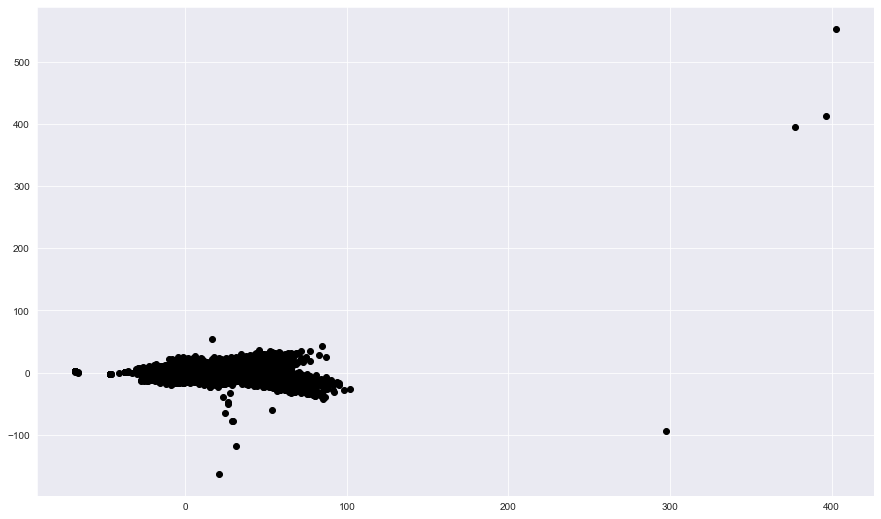

In [12]:
fig = plt.figure(figsize=(15, 9))
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(read_data['x1'], read_data['x2'], color = 'black', label = 'pca')

In [13]:
train = read_data

In [15]:
valid_set = pd.read_csv('03_31/VIB_0331_pump_51200.csv', encoding = 'cp949',sep = '\t')

In [16]:
valid = data_process(valid_set.iloc[:47960000,1])
valid = pca(valid)

100%|█████████████████████████████████████████████████████████████████████████████| 9385/9385 [00:17<00:00, 523.43it/s]


In [17]:
abnormal_set = pd.read_csv('pump_abnormal1.csv',encoding='cp949')

In [18]:
abnormal_data = abnormal_set.to_numpy().reshape(-1)

In [19]:
abnormal_data = pd.DataFrame(abnormal_data)

In [20]:
abnormal = data_process(abnormal_data)

100%|███████████████████████████████████████████████████████████████████████████| 13906/13906 [00:58<00:00, 236.78it/s]


In [21]:
abnormal = pca(abnormal)

In [22]:
# #scaling
min_max_scaler = preprocessing.MinMaxScaler()
scaled_train = min_max_scaler.fit_transform(train)
scaled_valid = min_max_scaler.fit_transform(valid)
scaled_abnormal = min_max_scaler.fit_transform(abnormal)

#standard_scaler = preprocessing.StandardScaler()
# scaled_train = standard_scaler.fit_transform(train)
# scaled_valid = standard_scaler.fit_transform(valid)

# max_abs_scaler = preprocessing.MaxAbsScaler()
# scaled_train = scaling(train,max_abs_scaler)
# scaled_valid = scaling(valid,max_abs_scaler)
# scaled_abnormal = scaling(abnormal,max_abs_scaler)

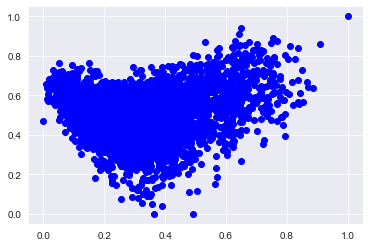

In [23]:
plt.scatter(scaled_valid[:,0], scaled_valid[:,1], color = 'blue', label = 'normal')

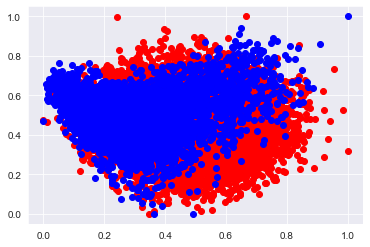

In [24]:
plt.scatter(scaled_abnormal[:,0], scaled_abnormal[:,1], color = 'red', label = 'abnormal')
plt.scatter(scaled_valid[:,0], scaled_valid[:,1], color = 'blue', label = 'normal')
#plt.scatter(X_outliers.iloc[:,0], X_outliers.iloc[:,1], color = 'red', label = 'abnormal')

plt.show()

In [25]:
from sklearn.neighbors import LocalOutlierFactor
#clf = IsolationForest(max_samples=10, contamination = 0.1, random_state=42)
clf = LocalOutlierFactor(n_neighbors=1000,novelty=True)

In [26]:
#train_model(clf,scaled_valid,batch_size = 1000)      

In [27]:
clf.fit(scaled_train)

LocalOutlierFactor(n_neighbors=1000, novelty=True)

In [28]:
anomaly_scores = get_anomaly_scores(clf,scaled_valid)

In [29]:
outliers = get_anomaly_scores(clf,abnormal)

In [30]:
anomaly_scores = pd.DataFrame(anomaly_scores.reshape(-1) ,columns=['x1'])

In [31]:
outliers = pd.DataFrame(outliers.reshape(-1) ,columns=['x1'])

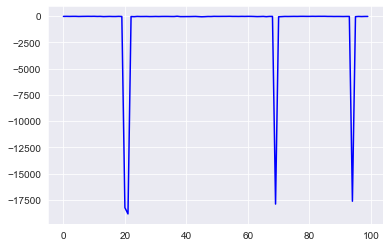

In [32]:
plt.plot(anomaly_scores[:100].index,
         anomaly_scores[:100],
          color='blue', label="normal")

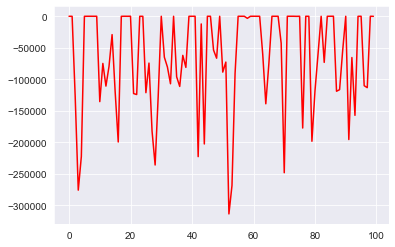

In [33]:
plt.plot(outliers[:100].index,
         outliers[:100],
          color='red', label="anomaly")


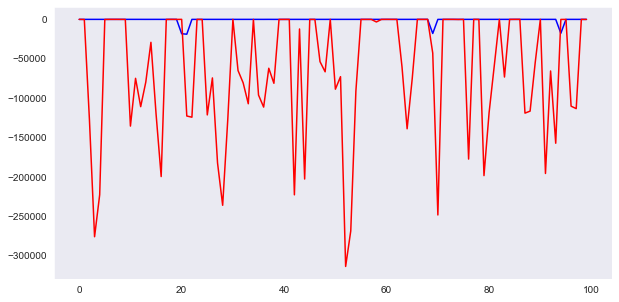

In [34]:
plt.figure(figsize=(10,5))

plt.plot(anomaly_scores[:100].index,
         anomaly_scores[:100],
          color='blue', label="normal")

plt.plot(outliers[:100].index,
         outliers[:100],
          color='red', label="anomaly")


plt.grid()

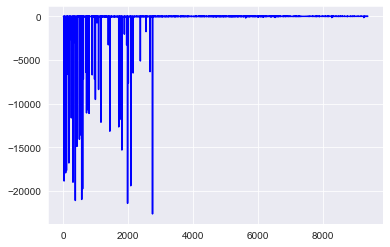

In [35]:
plt.plot(anomaly_scores.index,
         anomaly_scores,
          color='blue', label="normal")

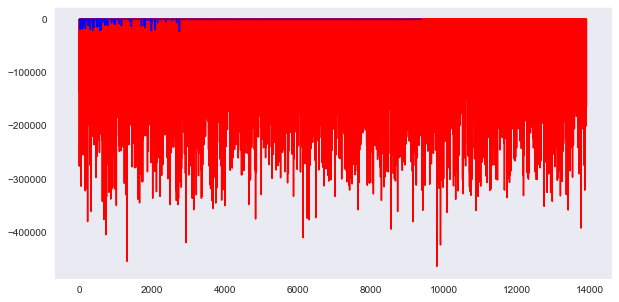

In [36]:
plt.figure(figsize=(10,5))
plt.plot(outliers.index,
         outliers,
          color='red', label="anomaly")

plt.plot(anomaly_scores.index,
         anomaly_scores,
          color='blue', label="normal")



plt.grid()

In [191]:
joblib.dump(clf, 'IF_Model_20220408_motor_minmax_2feature_v1.pkl') 

['IF_Model_20220408_motor_minmax_2feature_v1.pkl']

In [57]:
joblib.dump(min_max_scaler, 'IF_MinMaxScaler_20220406_pump_minmax_v1.pkl') 

['IF_MinMaxScaler_20220406_motor_minmax_v1.pkl']

In [195]:
clf = joblib.load('IF_Model_20220408_motor_minmax_2feature_v1.pkl')